
## 1- Pneumonia classification using transfer learning with Keras







The aim of this project is to use transfer learning to detect pneumonia on XRay images (converted to .jpeg). We are going to test different models (VGG16, VGG19 and InceptionV3) and compare their performance.

Pneumonia : (From Wikipedia)


>  is an inflammatory condition of the lung primarily affecting the small air sacs known as alveoli. Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. Diagnosis is often based on symptoms and physical examination. Chest X-rays, blood tests, and culture of the sputum may help confirm the diagnosis.



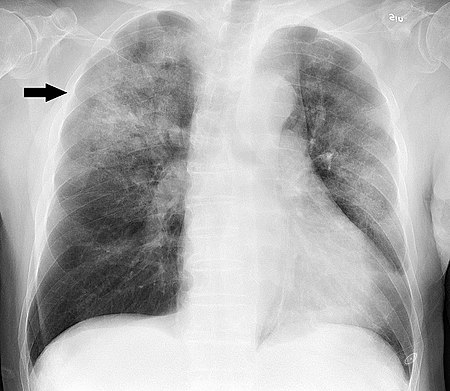

Please download the dataset from the below url

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

## Data collection (from Kaggle)

In [2]:
!pip install kaggle

In [3]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sammdl8","key":"afd3cb05f9bd1d4f18a4ab2330c37714"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json  ~/.kaggle/

#change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:31<00:00, 26.8MB/s]
100% 2.29G/2.29G [00:31<00:00, 77.5MB/s]


In [6]:
from zipfile import ZipFile
file_name= 'chest-xray-pneumonia.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


# Data visualization

Our dataset contains three folders:

1.   Train
2.   Test
3.   Validation

Note that our dataset is replicated (we do not consider "chest_xray folder" contained in the dataset folder).

> We have two classes of data: 


1.   NORMAL: absence of pneumonia
2.   PNEUMONIA: presence of pneumonia







In [7]:
from glob import glob
# useful for getting number of output classes
folders = glob('/content/chest_xray/train/*')

In [8]:
train_normal_path = '/content/chest_xray/train/NORMAL'
train_pneumonia_path = '/content/chest_xray/train/PNEUMONIA'
test_normal_path = '/content/chest_xray/test/NORMAL'
test_pneumonia_path = '/content/chest_xray/test/PNEUMONIA'

In [9]:
import os

list1 = os.listdir(train_normal_path)
n1 = len(list1)

list2 = os.listdir(train_pneumonia_path)
n2 = len(list2)

list3 = os.listdir(test_normal_path)
n3 = len(list3)

list4 = os.listdir(test_pneumonia_path)
n4 = len(list4)
print("Train set: Number of images of \nNormal cases:         "+str(n1)+
      "\nPneumonia cases:      "+str(n2)+
      "\nTotal training set:             "+str(n1+n2)+
      "\n\nTest set: Number of images of\nNormal cases:         "+str(n3)+
      "\nPneumonia cases:      "+str(n4)+
      "\nTotal test set:                 "+str(n3+n4)
)



Train set: Number of images of 
Normal cases:         1341
Pneumonia cases:      3875
Total training set:             5216

Test set: Number of images of
Normal cases:         234
Pneumonia cases:      390
Total test set:                 624


As we see the dataset is unbalanced especially in training set: the number of images representing pneumonia class is approximately 3 times the number of images representing normal class.

We are going to visualize random examples of the two classes: NORMAL and PNEUMONIA

Normal

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


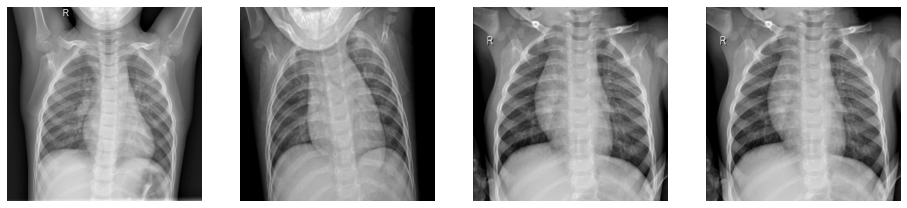

In [10]:
from fastai.vision import *
img1=open_image('/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg')
img1.resize(torch.Size([img1.shape[0],400, 400]))

img2=open_image('/content/chest_xray/train/NORMAL/IM-0133-0001.jpeg')
img2.resize(torch.Size([img2.shape[0],400, 400]))

img3=open_image('/content/chest_xray/train/NORMAL/IM-0288-0001.jpeg')
img3.resize(torch.Size([img3.shape[0],400, 400]))

img4=open_image('/content/chest_xray/train/NORMAL/IM-0446-0001.jpeg')
img4.resize(torch.Size([img3.shape[0],400, 400]))

_,axs = plt.subplots(1,4, figsize=(16,8))

img1.show(ax=axs[0])
img2.show(ax=axs[1])
img3.show(ax=axs[2])
img3.show(ax=axs[3])

PNEUMONIA

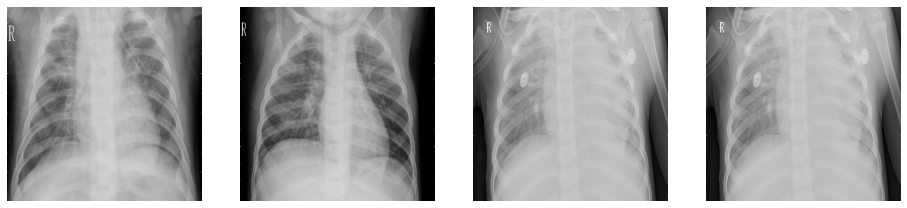

In [11]:
from fastai.vision import *
img1=open_image('/content/chest_xray/train/PNEUMONIA/person1003_virus_1685.jpeg')
img1.resize(torch.Size([img1.shape[0],400, 400]))

img2=open_image('/content/chest_xray/train/PNEUMONIA/person1395_virus_2398.jpeg')
img2.resize(torch.Size([img2.shape[0],400, 400]))

img3=open_image('/content/chest_xray/train/PNEUMONIA/person1308_bacteria_3288.jpeg')
img3.resize(torch.Size([img3.shape[0],400, 400]))

img4=open_image('/content/chest_xray/train/PNEUMONIA/person1449_bacteria_3743.jpeg')
img4.resize(torch.Size([img3.shape[0],400, 400]))

_,axs = plt.subplots(1,4, figsize=(16,8))

img1.show(ax=axs[0])
img2.show(ax=axs[1])
img3.show(ax=axs[2])
img3.show(ax=axs[3])

Import libraries

In [12]:
# import the libraries as shown below

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

Now we are going to implement different models based on famous pretrained models (VGG16, VGG19, InceptionV3) and compare their performance.


> Let's begin with VGG16



## VGG16

The following architecture is taken from this link: https://neurohive.io/en/popular-networks/vgg16/

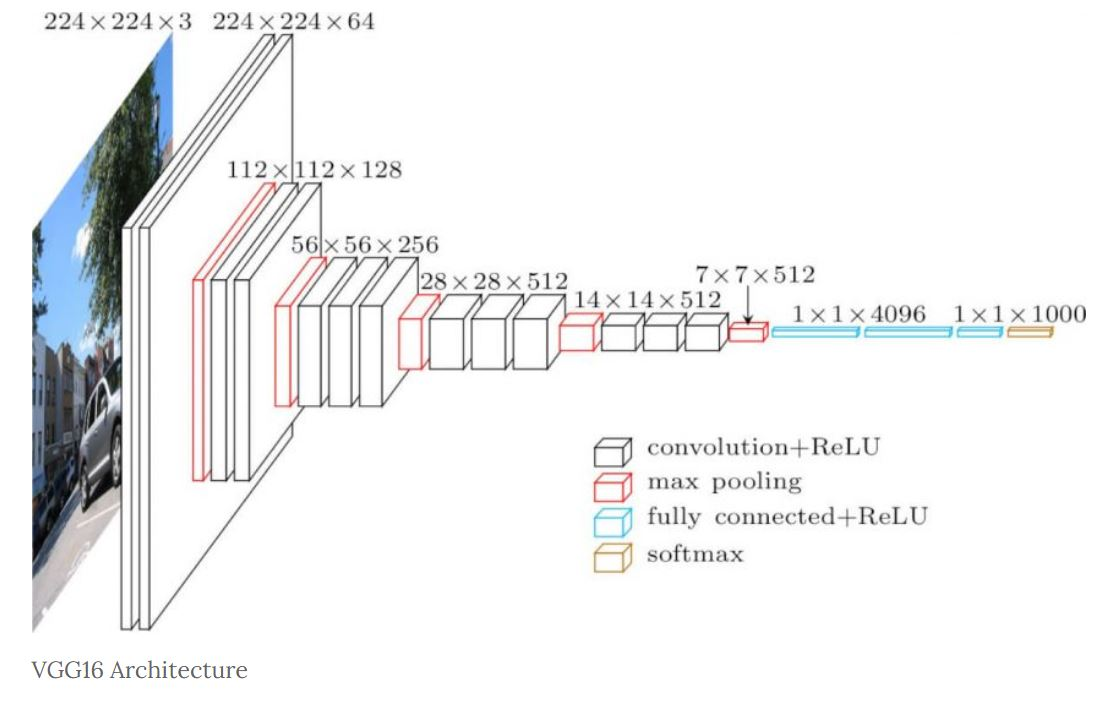

We are going to use a pretrained model called VGG16. 


> In fact we use weights of the VGG16 trained on ImageNet dataset. But we remove the fully connected layer of this model because in our case we have only two outputs (normal and pneumonia) and not 22000 categories.



In [13]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

IMAGE_SIZE=[224,224]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)




58892288/58889256 [==============================] - 0s 0us/step


In [14]:
# we keep existing weights
for layer in vgg.layers:
    layer.trainable = False

In [15]:
# our layers
x = Flatten()(vgg.output)

We use softmax for prediction because we have two classes (normal and pneumonia)

In [16]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [17]:

# view the structure of the model
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

We create a data generator with Keras for image augmentation. Data augmentation is a crucial step to boost our model's aptitude to generalize.



In [18]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [19]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [20]:
test_set = test_datagen.flow_from_directory('/content/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [21]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [22]:
# fit the model

r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=4,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
163/163 [==============================] - 111s 629ms/step - loss: 0.5487 - accuracy: 0.8261 - val_loss: 0.2359 - val_accuracy: 0.9119
Epoch 2/4
163/163 [==============================] - 102s 624ms/step - loss: 0.1151 - accuracy: 0.9592 - val_loss: 0.2767 - val_accuracy: 0.9071
Epoch 3/4
163/163 [==============================] - 102s 624ms/step - loss: 0.0866 - accuracy: 0.9676 - val_loss: 0.2765 - val_accuracy: 0.9006
Epoch 4/4
163/163 [==============================] - 102s 623ms/step - loss: 0.0842 - accuracy: 0.9725 - val_loss: 0.2963 - val_accuracy: 0.9054


After training the model in four epochs we achieve the following results:


*   training accuracy = 0,9658
*   validation accyracy = 0,9183

Do not forget that our training set is unbalanced : the number of PNEUMONIA images is approximately 3 times larger than the NORMAL class. So by balancing our training set the model could perform much better.

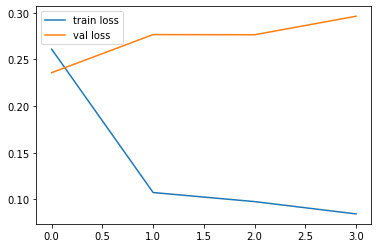

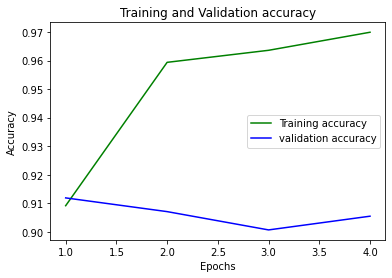

In [23]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
acc_train = r.history['accuracy']
acc_val = r.history['val_accuracy']
epochs = range(1,5)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
# save it as a h5 file

import tensorflow as tf

from keras.models import load_model

model.save('model_vgg16.h5')

After saving our model we upload it in order to diagnose new patients.

In [25]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

In [26]:
model=load_model('model_vgg16.h5')

Now we are going to test the validation of our model. For that we consider our validation set which contains 16 images: 8 NORMAL and 8 PNEUMONIA.


> For example we take one image from the class PNEUMONIA.



In [27]:
img=image.load_img('/content/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg',target_size=(224,224))

In [28]:
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
classes=model.predict(img_data)
classes

array([[0., 1.]], dtype=float32)

As we can see above the prediction is correct. This model can assist non specialist doctors to diagnose pneumonia disease.





## VGG19

The following architecture is taken from: https://saicharanars.medium.com/building-vgg19-with-keras-f516101c24cf

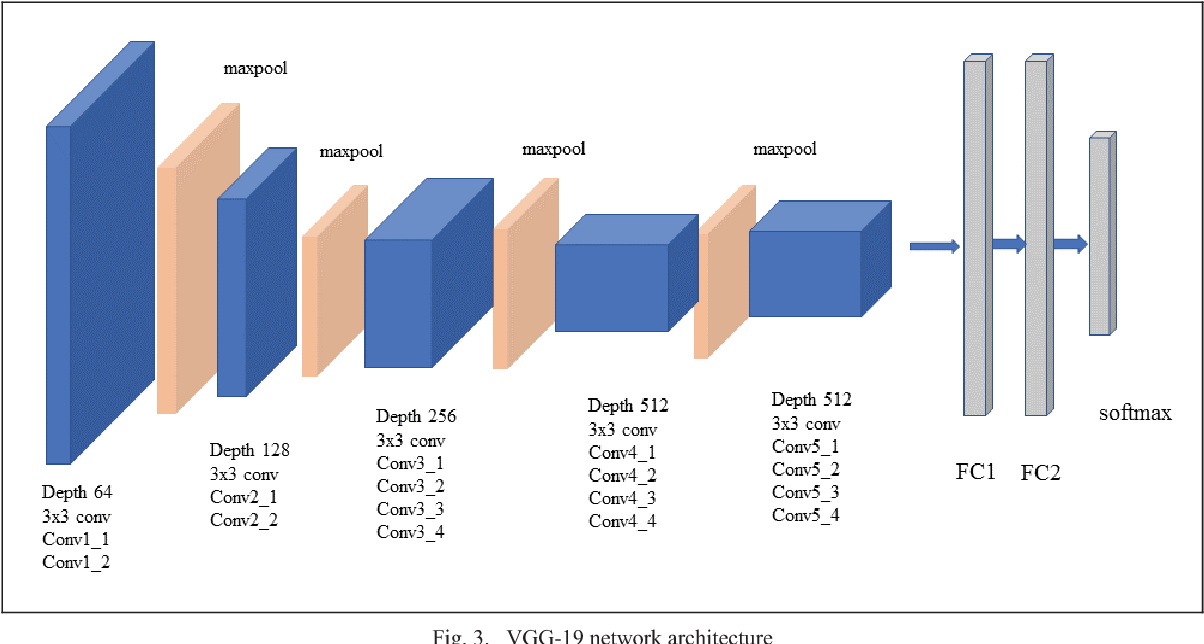

In [29]:
from keras.applications.vgg19 import VGG19
IMAGE_SIZE=[224,224]
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 0s 0us/step


In [30]:
# we keep existing weights
for layer in vgg.layers:
    layer.trainable = False

In [31]:
# our layers
x = Flatten()(vgg.output)

In [32]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [33]:
# view the structure of the model
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [34]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [35]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [36]:
test_set = test_datagen.flow_from_directory('/content/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [37]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [38]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=4,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
163/163 [==============================] - 105s 642ms/step - loss: 0.6380 - accuracy: 0.8245 - val_loss: 0.4249 - val_accuracy: 0.8413
Epoch 2/4
163/163 [==============================] - 104s 636ms/step - loss: 0.1313 - accuracy: 0.9440 - val_loss: 0.2794 - val_accuracy: 0.9038
Epoch 3/4
163/163 [==============================] - 104s 636ms/step - loss: 0.1336 - accuracy: 0.9518 - val_loss: 0.3817 - val_accuracy: 0.8766
Epoch 4/4
163/163 [==============================] - 104s 636ms/step - loss: 0.0992 - accuracy: 0.9633 - val_loss: 0.3168 - val_accuracy: 0.9103


In [39]:
(619+612+611+614)/4

614.0

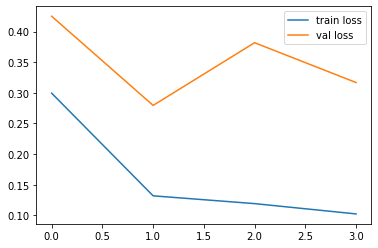

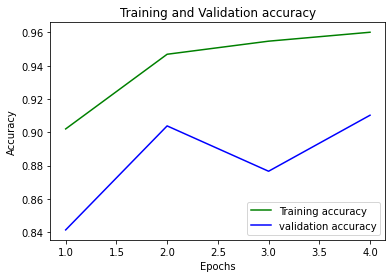

In [40]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
acc_train = r.history['accuracy']
acc_val = r.history['val_accuracy']
epochs = range(1,5)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
# save it as a h5 file

import tensorflow as tf

from keras.models import load_model

model.save('model_vgg19.h5')

In [42]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
import numpy as np

In [43]:
model=load_model('model_vgg19.h5')

In [44]:
img=image.load_img('/content/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg',target_size=(224,224))

In [45]:
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
classes=model.predict(img_data)
classes

array([[0.0016, 0.9984]], dtype=float32)

## InceptionV3

The following architecture is taken from: https://paperswithcode.com/method/inception-v3#

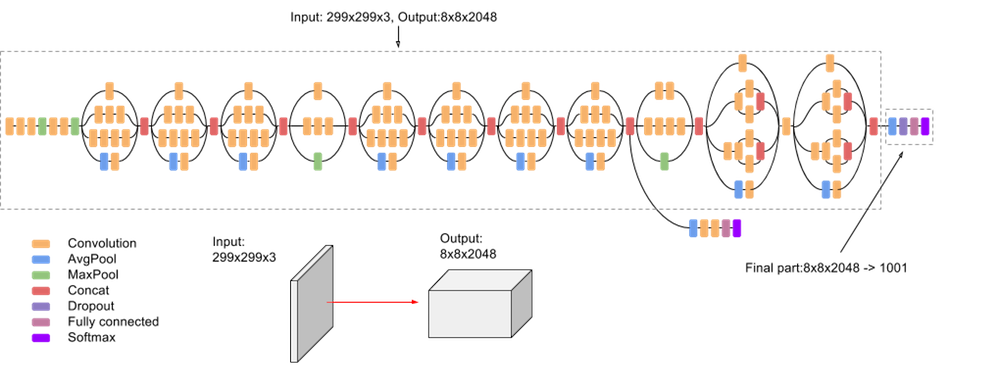

In [46]:
from keras.applications.inception_v3 import InceptionV3
IMAGE_SIZE=[224,224]
vgg = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [47]:
# we keep existing weights
for layer in vgg.layers:
    layer.trainable = False

In [48]:
# our layers
x = Flatten()(vgg.output)

In [49]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [50]:
# view the structure of the model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [51]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [52]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [53]:
test_set = test_datagen.flow_from_directory('/content/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [54]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [55]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=4,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
163/163 [==============================] - 106s 626ms/step - loss: 0.8582 - accuracy: 0.8780 - val_loss: 1.0335 - val_accuracy: 0.8670
Epoch 2/4
163/163 [==============================] - 100s 614ms/step - loss: 0.4948 - accuracy: 0.9343 - val_loss: 1.8882 - val_accuracy: 0.8413
Epoch 3/4
163/163 [==============================] - 100s 614ms/step - loss: 0.5985 - accuracy: 0.9379 - val_loss: 2.4259 - val_accuracy: 0.8173
Epoch 4/4
163/163 [==============================] - 100s 613ms/step - loss: 0.4942 - accuracy: 0.9456 - val_loss: 1.6890 - val_accuracy: 0.8590


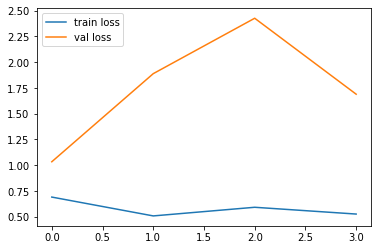

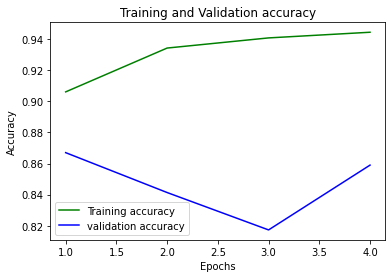

In [56]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
acc_train = r.history['accuracy']
acc_val = r.history['val_accuracy']
epochs = range(1,5)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [57]:
# save it as a h5 file

import tensorflow as tf

from keras.models import load_model

model.save('model_inceptionv3.h5')

In [58]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
import numpy as np

In [59]:
model=load_model('model_inceptionv3.h5')

In [60]:
img=image.load_img('/content/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg',target_size=(224,224))

In [61]:
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
classes=model.predict(img_data)
classes

array([[3.704202e-05, 9.999629e-01]], dtype=float32)

Here for example the InceptionV3 model makes an error of prediction: the image is predicted to be normal whereas it is associated to pneumonia class.

# Comparison between models

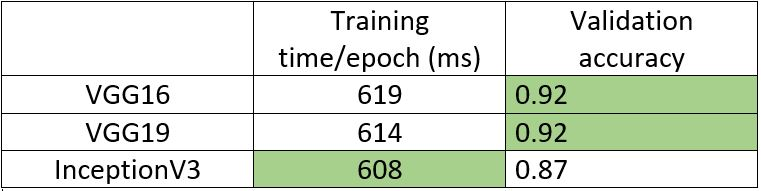

 
 

*   One one hand VGG19 and VGG16 outperform InceptionV3 in terms of accuracy. On the other hand the three algorithms perform closely in terms of computational speed.
*   We compared our models only in terms of accuracy and computational speed. But this is not sufficient: we have to consider other important metrics such as f1_score, recall, precision.
*   There are many other interesting models to test such as MobileNet, EfficientNet, ResNet...

